### in this notebook we'll compare the ground truth bboxes to predicted bboxes

the ground truth bboxes are compared to the predicted bboxes and the precision and recall are calculated per image for a given confidence threshold and iou threshold

In [1]:
import json
import os
import cv2
import matplotlib.pyplot as plt

In [57]:
labels = ['person','bicycle','car','motorcycle','airplane','bus','train','truck','boat','traffic light','fire hydrant','street sign','stop sign','parking meter','bench','bird','cat','dog','horse','sheep','cow','elephant','bear','zebra','giraffe','hat','backpack','umbrella','shoe','eye glasses','handbag','tie','suitcase','frisbee','skis','snowboard','sports ball','kite','baseball bat','baseball glove','skateboard','surfboard','tennis racket','bottle','plate','wine glass','cup','fork','knife','spoon','bowl','banana','apple','sandwich','orange','broccoli','carrot','hot dog','pizza','donut','cake','chair','couch','potted plant','bed','mirror','dining table','window','desk','toilet','door','tv','laptop','mouse','remote','keyboard','cell phone','microwave','oven','toaster','sink','refrigerator','blender','book','clock','vase','scissors','teddy bear','hair drier','toothbrush','hair brush']

### get the ground truth bboxes 

In [2]:
with open('../my_custom_dataset/annotations/coco_annotation.json', 'r') as f:
    data = json.load(f)

In [3]:
data.keys()

dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])

get all bounding boxes given an image filename

In [4]:
data['images'][0]

{'license': 4,
 'file_name': '000000397133.jpg',
 'coco_url': 'http://images.cocodataset.org/val2017/000000397133.jpg',
 'height': 427,
 'width': 640,
 'date_captured': '2013-11-14 17:02:52',
 'flickr_url': 'http://farm7.staticflickr.com/6116/6255196340_da26cf2c9e_z.jpg',
 'id': 397133}

In [5]:
data['annotations'][0]

{'segmentation': [[125.12,
   539.69,
   140.94,
   522.43,
   100.67,
   496.54,
   84.85,
   469.21,
   73.35,
   450.52,
   104.99,
   342.65,
   168.27,
   290.88,
   179.78,
   288.0,
   189.84,
   286.56,
   191.28,
   260.67,
   202.79,
   240.54,
   221.48,
   237.66,
   248.81,
   243.42,
   257.44,
   256.36,
   253.12,
   262.11,
   253.12,
   275.06,
   299.15,
   233.35,
   329.35,
   207.46,
   355.24,
   206.02,
   363.87,
   206.02,
   365.3,
   210.34,
   373.93,
   221.84,
   363.87,
   226.16,
   363.87,
   237.66,
   350.92,
   237.66,
   332.22,
   234.79,
   314.97,
   249.17,
   271.82,
   313.89,
   253.12,
   326.83,
   227.24,
   352.72,
   214.29,
   357.03,
   212.85,
   372.85,
   208.54,
   395.87,
   228.67,
   414.56,
   245.93,
   421.75,
   266.07,
   424.63,
   276.13,
   437.57,
   266.07,
   450.52,
   284.76,
   464.9,
   286.2,
   479.28,
   291.96,
   489.35,
   310.65,
   512.36,
   284.76,
   549.75,
   244.49,
   522.43,
   215.73,
   546.88,


In [95]:
img_name = '000000397133.jpg'

In [10]:
img_id = int(img_name.replace('0','').replace('.jpg',''))

In [11]:
img_id

397133

In [14]:
annotations = data['annotations']
gt_bboxes = []
for annot in annotations:
    if annot['image_id'] == img_id:
        gt_bboxes.append(annot['bbox'])

In [15]:
gt_bboxes

[[388.66, 69.92, 109.41, 277.62], [0.0, 262.81, 62.16, 36.77]]

In [16]:
img_root = '../my_custom_dataset/images/'

In [322]:
def get_gt(img_name):
    img_id = int(img_name.replace('.jpg',''))
    annotations = data['annotations']
    gt = []
    for annot in annotations:
        if annot['image_id'] == img_id:
            gt.append([annot['bbox'], annot['category_id']])
    return gt

In [323]:
get_gt(img_name)

[[[180.91, 201.49, 89.98, 209.63], 1],
 [[101.35, 193.08, 81.69, 231.92], 1],
 [[209.16, 63.99, 200.56, 343.82], 22],
 [[372.47, 202.47, 54.44, 165.23], 1]]

In [84]:
def viz_gt(img_root, img_name):
    filepath = os.path.join(img_root, img_name)
    img = cv2.imread(filepath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    gt = get_gt(img_name)
    for gti in gt:
        gt_bbox, category = gti
        xmin, ymin, width, height = map(int, gt_bbox)
        cv2.putText(img, labels[category-1], (xmin, ymin+10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 2)
        cv2.rectangle(img, (xmin, ymin), (xmin+width, ymin+height), (0, 255, 0), 1)
    
    plt.figure(figsize=(10,7))
    plt.imshow(img)

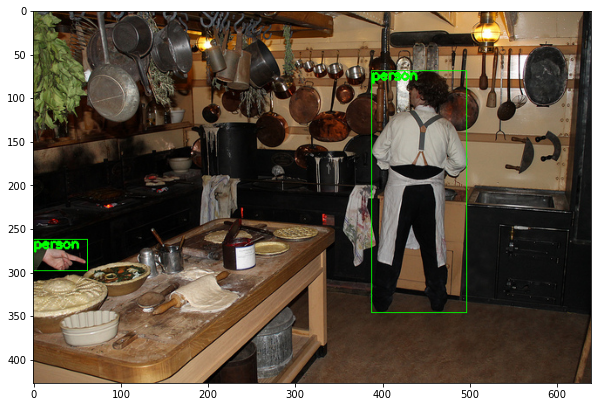

In [85]:
viz_gt(img_root, img_name)

### get the prediction from the loaded model 

In [37]:
import tensorflow_hub as hub
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [41]:
model = hub.KerasLayer("https://tfhub.dev/tensorflow/efficientdet/lite0/detection/1")

In [44]:
def get_prediction(model, img_name):
    filepath = os.path.join(img_root, img_name)
    image = Image.open(filepath)
    imagetensor = tf.convert_to_tensor(image, dtype=tf.uint8, dtype_hint=None, name=None)
    imagetensor_reshaped = tf.expand_dims(imagetensor, axis=0, name=None)
    boxes, scores, classes, num_detections = model(imagetensor_reshaped)
    return boxes, scores, classes, num_detections

In [45]:
boxes, scores, classes, num_detections = get_prediction(model, img_name)

In [79]:
boxes[0][0]

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([ 68.41437, 385.58307, 348.72223, 499.50073], dtype=float32)>

In [58]:
def viz_pred(model, img_name, proba_threshold=0.5):
    img_path = os.path.join(img_root, img_name)
    boxes, scores, classes, num_detections = get_prediction(model, img_name)
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    for i, score in enumerate(scores[0]):
        if score > proba_threshold:
            index = i
            labelindex = int(classes[0][index].numpy()) - 1
            ymin, xmin, ymax, xmax = map(int, boxes[0][index].numpy())
            cv2.putText(image, labels[labelindex], (xmin, ymin-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 2)
            cvrect = cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (255,255,255), 1)
    plt.figure(figsize=(10,10))
    plt.imshow(image)

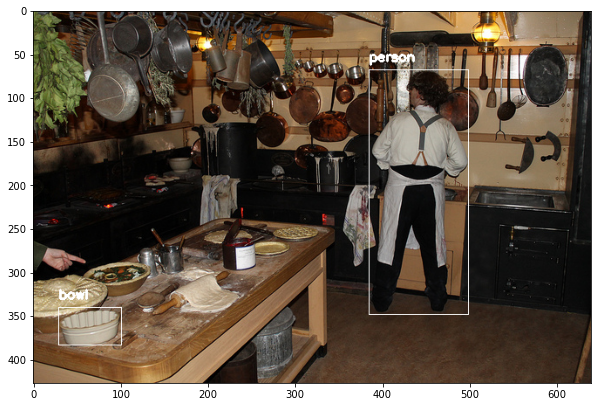

In [59]:
viz_pred(model, img_name, 0.5)

### visualize both the prediction and the ground truth 

**NOTE!!** Remember that the coco dataset that is being used it filtered and only has labels belonging to the super categories of 'person' and 'animal'

In [93]:
def viz_gt_and_pred(model, img_root, img_name, proba_threshold=0.5):
    filepath = os.path.join(img_root, img_name)
    img = cv2.imread(filepath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # get ground truth bboxes
    gt = get_gt(img_name)
    for gti in gt:
        gt_bbox, category = gti
        xmin, ymin, width, height = map(int, gt_bbox)
        cv2.putText(img, labels[category-1], (xmin, ymin+10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 2)
        cv2.rectangle(img, (xmin, ymin), (xmin+width, ymin+height), (0, 255, 0), 1)
        
    # get predictions
    boxes, scores, classes, num_detections = get_prediction(model, img_name)
    for i, score in enumerate(scores[0]):
        if score > proba_threshold:
            index = i
            labelindex = int(classes[0][index].numpy()) - 1
            ymin, xmin, ymax, xmax = map(int, boxes[0][index].numpy())
            cv2.putText(img, labels[labelindex], (xmin, ymin-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 2)
            cvrect = cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (255,0,0), 1)
    
    plt.figure(figsize=(10,7))
    plt.imshow(img)

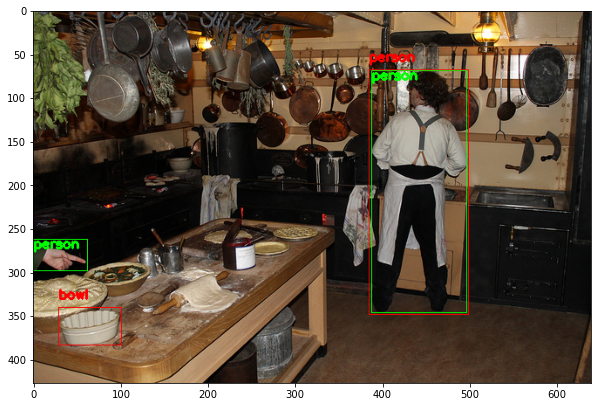

In [96]:
viz_gt_and_pred(model, img_root, img_name, 0.5)

### test a few more examples

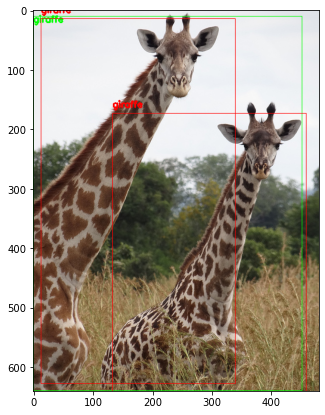

In [88]:
img_name = '000000079188.jpg'
viz_gt_and_pred(model, img_root, img_name, 0.5)

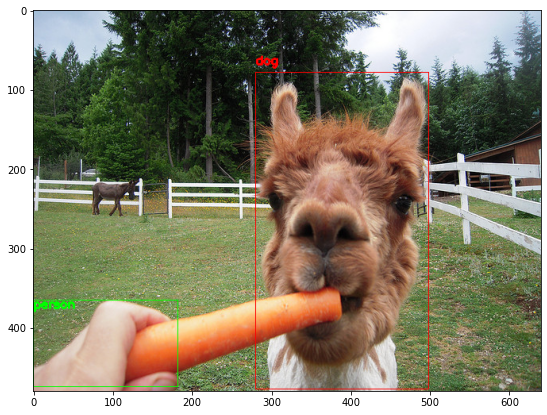

In [89]:
img_name = '000000113235.jpg'
viz_gt_and_pred(model, img_root, img_name, 0.5)

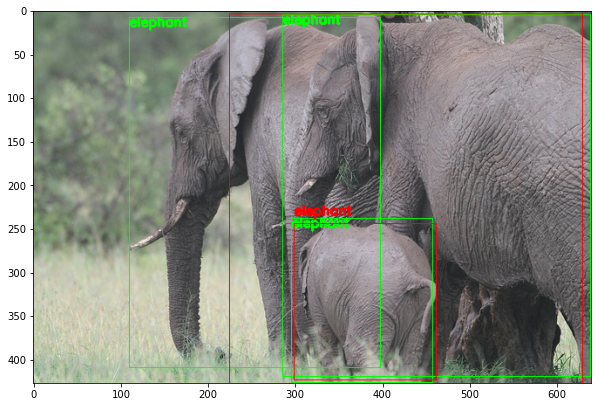

In [90]:
img_name = '000000167128.jpg'
viz_gt_and_pred(model, img_root, img_name, 0.5)

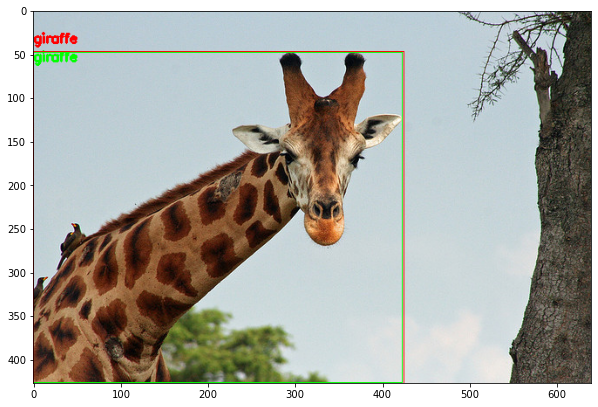

In [91]:
img_name = '000000216739.jpg'
viz_gt_and_pred(model, img_root, img_name, 0.5)

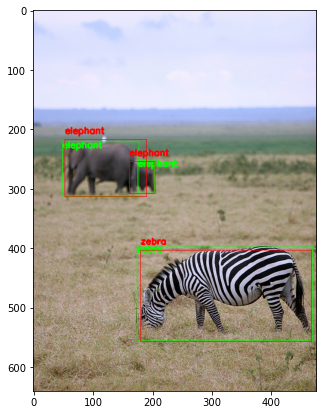

In [104]:
img_name = '000000379533.jpg'
viz_gt_and_pred(model, img_root, img_name, 0.5)

### get precision for a single image

#### calculate iou given a set of bboxes for ground truth and predictions  

In [120]:
filepath = os.path.join(img_root, img_name)
img = cv2.imread(filepath)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# get ground truth bboxes
gt = get_gt(img_name)

# get predictions
boxes, scores, classes, num_detections = get_prediction(model, img_name)


In [121]:
gt

[[[49.72, 221.14, 128.58, 91.69], 22],
 [[175.73, 252.72, 28.03, 55.54], 22],
 [[174.27, 396.31, 294.24, 159.78], 24]]

In [122]:
classes

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[24., 22., 22., 24., 22., 22., 22., 16., 22., 22., 22., 24., 22.,
        22., 22., 22., 22., 16., 22., 22., 16., 22., 22., 22., 24., 24.,
        22., 22., 22., 24., 24., 22., 22., 22., 22., 22., 22., 22., 22.,
        22., 22., 24., 24., 24., 22., 22., 22., 22., 22., 24., 22., 16.,
        24., 22., 24., 22., 24., 24., 22., 22., 22., 22., 22., 24., 24.,
        22., 22., 22., 22., 24., 24., 22., 24., 24., 16., 22., 16., 22.,
        22., 22., 22., 24., 22., 16., 22., 24., 24., 22., 24., 22., 22.,
        16., 22., 24., 22., 22., 24., 22., 22., 22.]], dtype=float32)>

In [123]:
scores

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[0.84431094, 0.73670447, 0.5126484 , 0.13455291, 0.13336557,
        0.12545153, 0.08708699, 0.07334541, 0.06828027, 0.06576993,
        0.05434197, 0.0502571 , 0.04099799, 0.03749738, 0.03232466,
        0.03063333, 0.0300841 , 0.02826884, 0.02732596, 0.02719339,
        0.02653931, 0.02522818, 0.02469163, 0.02146838, 0.02110434,
        0.02091337, 0.0208042 , 0.01998639, 0.01893911, 0.0189274 ,
        0.01769568, 0.01735025, 0.01650045, 0.01645911, 0.01644598,
        0.01621686, 0.01599771, 0.01553902, 0.01548852, 0.0154487 ,
        0.01530153, 0.01504381, 0.01485387, 0.01444574, 0.01417691,
        0.01387755, 0.01367043, 0.01360643, 0.01350332, 0.01295608,
        0.01282006, 0.01237988, 0.01230023, 0.01225691, 0.01203612,
        0.01200145, 0.01179521, 0.01156198, 0.01153121, 0.01148093,
        0.01146419, 0.01116761, 0.0109529 , 0.01074877, 0.01066952,
        0.01063718, 0.01043173, 0.01024071, 0.01000099, 0.00982043

In [124]:
boxes[0][:4]

<tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[403.37057 , 180.25116 , 556.11    , 466.2862  ],
       [217.9716  ,  53.815224, 313.38278 , 190.71194 ],
       [254.4057  , 161.86807 , 308.06995 , 204.51114 ],
       [402.90567 , 174.92542 , 554.3395  , 461.4137  ]], dtype=float32)>

In [125]:
labels[23]

'zebra'

In [147]:
# convert the bboxes to the format xmin, ymin, xmax, ymax
preds = []
conf_thresh = 0.5
for box, cls, score in zip(boxes[0], classes[0], scores[0]):
    if score > conf_thresh:
        ymin, xmin, ymax, xmax = box.numpy()
        preds.append([[xmin, ymin, xmax, ymax], cls.numpy()])

gtruths = []
for gti in gt:
    xmin, ymin, width, height = gti[0]
    cls = gti[1]
    gtruths.append([[xmin, ymin, xmax+width, ymax+height], cls])
    
print('ground truths:\n', gtruths)
print('preds:\n', preds)

ground truths:
 [[[49.72, 221.14, 333.09113891601567, 399.7599462890625], 22], [[175.73, 252.72, 232.54113891601563, 363.6099462890625], 22], [[174.27, 396.31, 498.75113891601563, 467.8499462890625], 24]]
preds:
 [[[180.25116, 403.37057, 466.2862, 556.11], 24.0], [[53.815224, 217.9716, 190.71194, 313.38278], 22.0], [[161.86807, 254.4057, 204.51114, 308.06995], 22.0]]


### put everything in a function 

given an input image, get the gtruths, predictions and return the bboxes for both

In [178]:
def get_bboxes_classes(model, img_root, img_name, conf_thresh=0.5):
    '''
    given an input image, get the gtruths, predictions and return the bboxes for both
    returned bboxes are in the format xmin, ymin, xmax, ymax
    '''
    filepath = os.path.join(img_root, img_name)
    img = cv2.imread(filepath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # get ground truth bboxes
    gt = get_gt(img_name)

    # get predictions
    boxes, scores, classes, num_detections = get_prediction(model, img_name)
    
    # convert the bboxes to the format xmin, ymin, xmax, ymax
    preds = []
    conf_thresh = 0.5
    for box, cls, score in zip(boxes[0], classes[0], scores[0]):
        if score > conf_thresh:
            ymin, xmin, ymax, xmax = box.numpy()
            preds.append([[xmin, ymin, xmax, ymax], cls.numpy()])

    gtruths = []
    for gti in gt:
        xmin, ymin, width, height = gti[0]
        cls = gti[1]
        gtruths.append([[xmin, ymin, xmin+width, ymin+height], cls])
    
    return gtruths, preds

In [179]:
model = hub.KerasLayer("https://tfhub.dev/tensorflow/efficientdet/lite0/detection/1")
img_root = '../my_custom_dataset/images/'

In [232]:
img_name = '000000397133.jpg'
gtruths, preds = get_bboxes_classes(model, img_root, img_name, 0.5)

In [181]:
gtruths, preds

([[[388.66, 69.92, 498.07000000000005, 347.54], 1],
  [[0.0, 262.81, 62.16, 299.58], 1]],
 [[[385.58307, 68.41437, 499.50073, 348.72223], 1.0],
  [[29.564056, 340.40274, 101.15805, 383.73764], 51.0]])

In [252]:
img_name = '000000379533.jpg'
gtruths, preds = get_bboxes_classes(model, img_root, img_name, 0.5)

In [254]:
gtruths, preds

([[[49.72, 221.14, 178.3, 312.83], 22],
  [[175.73, 252.72, 203.76, 308.26], 22],
  [[174.27, 396.31, 468.51, 556.09], 24]],
 [[[180.25116, 403.37057, 466.2862, 556.11], 24.0],
  [[53.815224, 217.9716, 190.71194, 313.38278], 22.0],
  [[161.86807, 254.4057, 204.51114, 308.06995], 22.0]])

In [182]:
def get_iou(box_pred, box_label):
    '''
    function that takes in the coordinates of two rectangles and returns their IOU. 
    bbox format should be xmin, ymin, xmax, ymax
    '''
    # find the coordinates of the intersection box
    x1_pred = box_pred[0]
    y1_pred = box_pred[1]
    x2_pred = box_pred[2]
    y2_pred = box_pred[3]
    
    x1_label = box_label[0]
    y1_label = box_label[1]
    x2_label = box_label[2]
    y2_label = box_label[3]
    
    
    # intersection
    int_x1 = np.max([x1_pred, x1_label])
    int_y1 = np.max([y1_pred, y1_label])
    int_x2 = np.min([x2_pred, x2_label])
    int_y2 = np.min([y2_pred, y2_label])
    
    # .clip() is used for cases when the boxes do not intersect
    intersection = (int_x2 - int_x1).clip(0) * (int_y2 - int_y1).clip(0)
    
    # union
    pred_box_area = (x2_pred - x1_pred) * (y2_pred - y1_pred)
    label_box_area = (x2_label - x1_label) * (y2_label - y1_label)
    
    union = pred_box_area + label_box_area - intersection
    
#     print(f'int_x1:{int_x1}')
#     print(f'int_x2:{int_x2}')
#     print(f'int_y1:{int_y1}')
#     print(f'int_y2:{int_y2}')
#     print(f'intersection:{intersection}')
    
    # IOU
    iou = intersection / union
    
    return iou

In [281]:
def calc_precision_recall_one_image(gtruths, preds, iou_thresh):
    TP = 0
    FP = 0
    FN = 0
    TN = 0
    ious = []
    epsilon = 1e-6 # to prevent division by zero
    for gt in gtruths:
        match_found = False
        FN_increased = False
        increase_in_FN = 0
        for pred in preds:
            gt_bbox = gt[0]
            gt_cls = gt[1]
            pred_bbox = pred[0]
            pred_cls = pred[1]
            iou = get_iou(pred_bbox, gt_bbox)
            ious.append(iou)
#             print(pred_bbox, gt_bbox, iou)
            
    
            if iou > iou_thresh:
                if gt_cls == pred_cls:
                    TP += 1
                    match_found = True
                else:
                    FP += 1
                    match_found = True
            elif iou < 0.3:
                if gt_cls == pred_cls:
                    FN += 1
                    FN_increased = True
                    increase_in_FN += 1
                else:
                    TN += 1
#             print(TP, FP, FN, TN)
#             print(match_found, FN_increased)
        if match_found == True and FN_increased == True:
            # if a bbox with class zebra does not match with another bbox with class zebra (becasue their iou < iou_thresh), 
            # and they shouldnt match since they're separate objects, the FN count still goes up with the logic above. 
            # this is used to bring back down the FN count in case the zebra bbox matches with another zebra pred with 
            # an iou > iou thresh 
            FN -= increase_in_FN 
        

    precision = TP / (TP + FP + epsilon)
    recall = TP / (TP + FN + epsilon)
    return precision, recall

In [282]:
img_name = '000000379533.jpg'
gtruths, preds = get_bboxes_classes(model, img_root, img_name, 0.5)

In [283]:
precision, recall = calc_precision_recall_one_image(gtruths, preds, 0.6)
precision, recall

(0.9999996666667778, 0.9999996666667778)

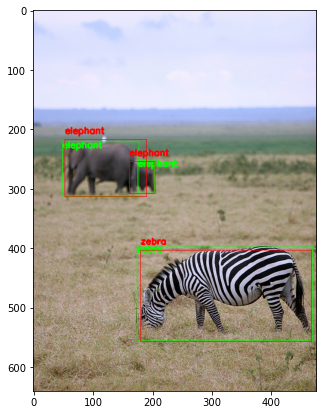

In [284]:
viz_gt_and_pred(model, img_root, img_name, 0.5)

### put everything in a function 

create a function that accepts an image an returns the precision and recall

In [285]:
def precision_recall_one_image(model, img_root, img_name, conf_thresh=0.5, iou_thresh=0.7):
    gtruths, preds = get_bboxes_classes(model, img_root, img_name, 0.5)
    precision, recall = calc_precision_recall_one_image(gtruths, preds, iou_thresh)
    
    return precision, recall

In [286]:
model = hub.KerasLayer("https://tfhub.dev/tensorflow/efficientdet/lite0/detection/1")
img_root = '../my_custom_dataset/images/'

### test the precision and recall of a few images 

### 1 

In [292]:
img_name = img_name = '000000397133.jpg'
precision, recall = precision_recall_one_image(model, img_root, img_name, 0.5, 0.6)
print(f'precision: {precision:.4f}, recall: {recall:.4f}')

precision: 1.0000, recall: 0.5000


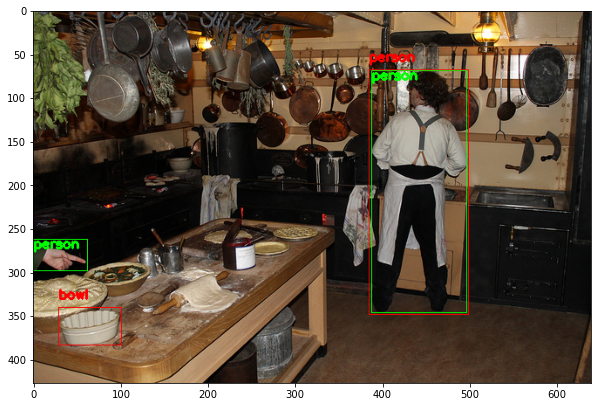

In [288]:
viz_gt_and_pred(model, img_root, img_name, 0.5)

### 2 

In [293]:
img_name = '000000379533.jpg'
precision, recall = precision_recall_one_image(model, img_root, img_name, 0.5, 0.6)
print(f'precision: {precision:.4f}, recall: {recall:.4f}')

precision: 1.0000, recall: 1.0000


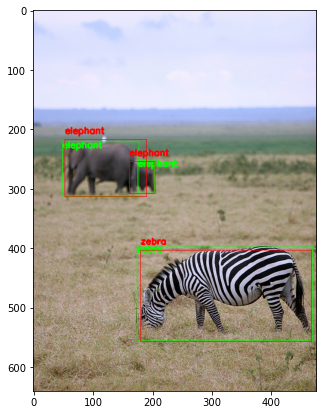

In [294]:
viz_gt_and_pred(model, img_root, img_name, 0.5)

### 3 

In [295]:
img_name = '000000052462.jpg'
precision, recall = precision_recall_one_image(model, img_root, img_name, 0.5, 0.6)
print(f'precision: {precision:.4f}, recall: {recall:.4f}')

precision: 1.0000, recall: 1.0000


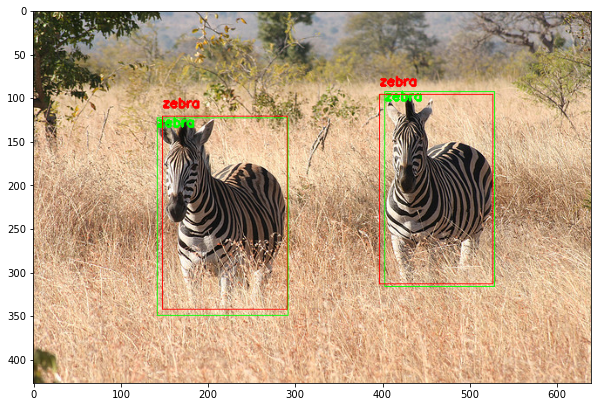

In [296]:
viz_gt_and_pred(model, img_root, img_name, 0.5)

### 4 

In [299]:
img_name = '000000059386.jpg'
precision, recall = precision_recall_one_image(model, img_root, img_name, 0.5, 0.6)
print(f'precision: {precision:.4f}, recall: {recall:.4f}')

precision: 1.0000, recall: 0.1667


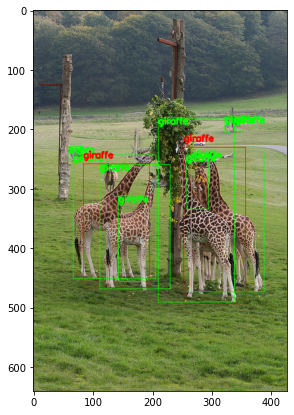

In [300]:
viz_gt_and_pred(model, img_root, img_name, 0.5)

the same image as above with an iou_threshold of 0.7 will return 0 precision and recall

In [301]:
img_name = '000000059386.jpg'
precision, recall = precision_recall_one_image(model, img_root, img_name, 0.5, 0.6)
print(f'precision: {precision:.4f}, recall: {recall:.4f}')

precision: 1.0000, recall: 0.1667


 ### 5 

In [324]:
img_name = '000000562207.jpg'
precision, recall = precision_recall_one_image(model, img_root, img_name, 0.5, 0.6)
print(f'precision: {precision:.4f}, recall: {recall:.4f}')

precision: 1.0000, recall: 1.0000


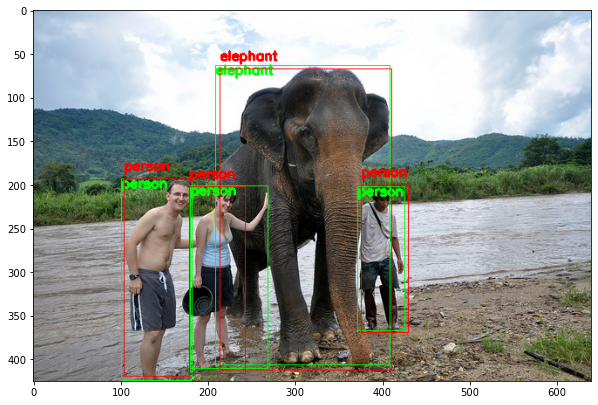

In [325]:
viz_gt_and_pred(model, img_root, img_name, 0.5)

### 6 

In [326]:
img_name = '000000571857.jpg'
precision, recall = precision_recall_one_image(model, img_root, img_name, 0.5, 0.6)
print(f'precision: {precision:.4f}, recall: {recall:.4f}')

precision: 1.0000, recall: 1.0000


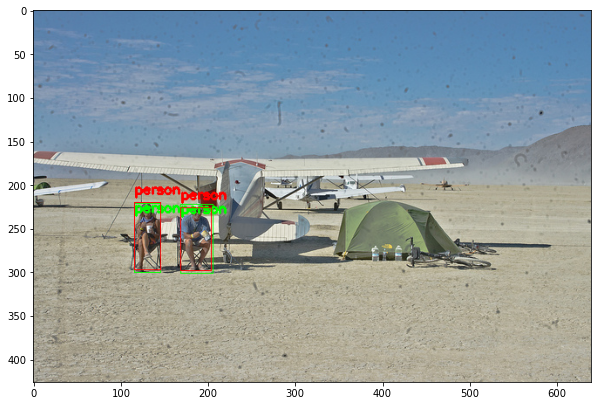

In [327]:
viz_gt_and_pred(model, img_root, img_name, 0.5)

### 7 

In [328]:
img_name = '000000581100.jpg'
precision, recall = precision_recall_one_image(model, img_root, img_name, 0.5, 0.6)
print(f'precision: {precision:.4f}, recall: {recall:.4f}')

precision: 1.0000, recall: 1.0000


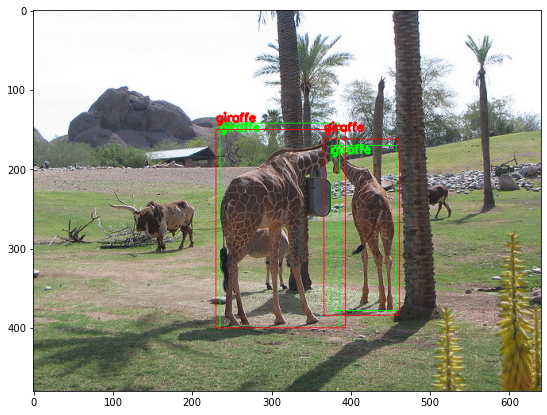

In [329]:
viz_gt_and_pred(model, img_root, img_name, 0.5)

remember that the coco dataset annotations are filtered, and the ground truth only has the classes: 'person', 'elephant', 'zebra', 'giraffe'

### 8 

In [330]:
img_name = '000000005037.jpg'
precision, recall = precision_recall_one_image(model, img_root, img_name, 0.5, 0.6)
print(f'precision: {precision:.4f}, recall: {recall:.4f}')

precision: 0.0000, recall: 0.0000


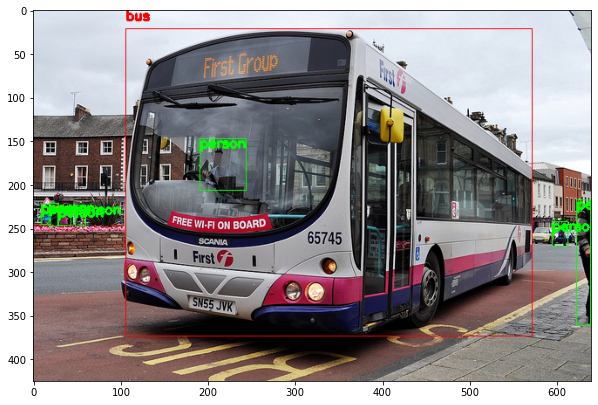

In [331]:
viz_gt_and_pred(model, img_root, img_name, 0.5)

## Conclusion

created a function that returns the precision and recall of the given model, per image

### appendix 

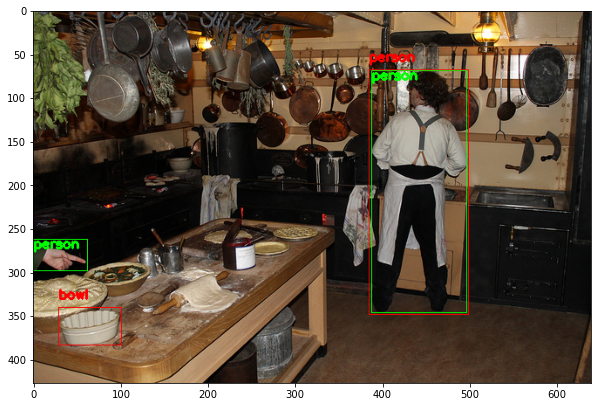

In [153]:
viz_gt_and_pred(model, img_root, img_name, 0.5)